# Custom Features

This notebook will build models using the custom features I came up with

In [1]:
# Importing libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import tqdm
import pickle

%matplotlib inline

In [2]:
# Getting the data
training = pd.read_csv('../../data/train.csv')
valid = pd.read_csv('../../data/validation.csv')

In [3]:
# Separating data into X and y
X_train = training.drop(['row_id','essay','LLM_written','prompt'],axis=1)
X_valid = valid.drop(['row_id','essay','LLM_written','prompt'],axis=1)
y_train = training['LLM_written'].values
y_valid = valid['LLM_written'].values

In [4]:
# Building the scalar
numerical = ['word_count','stop_word_count','stop_word_ratio','unique_word_count','unique_word_ratio',
             'count_question','count_exclamation','count_semi','count_colon','grammar_errors']
scalar = RobustScaler()
X_train[numerical] = scalar.fit_transform(X_train[numerical])
X_valid[numerical] = scalar.fit_transform(X_valid[numerical])

In [5]:
# Saving the scalar
with open('../../models/custom-features/scalar.pkl','wb') as file:
    pickle.dump(scalar,file)

In [6]:
# Creating a dictionary for the model performances
performances = {
    'model':[],
    'Train ROC AUC':[],
    'Valid ROC AUC':[]
}

## Logistic Regression 

In [7]:
# Building the model
log_reg = LogisticRegression(penalty='l2',C=0.8,class_weight='balanced',random_state=42,max_iter=1000)
log_reg.fit(X_train,y_train)

LogisticRegression(C=0.8, class_weight='balanced', max_iter=1000,
                   random_state=42)

In [8]:
# Making predictions
print('Predictions for Logistic Regression')
train_preds = log_reg.predict_proba(X_train)[:,1]
valid_preds = log_reg.predict_proba(X_valid)[:,1]
train_score = roc_auc_score(y_train,train_preds)
valid_score = roc_auc_score(y_valid,valid_preds)
print(f'Training ROC AUC: {train_score}')
print(f'Validation ROC AUC: {valid_score}')

Predictions for Logistic Regression
Training ROC AUC: 0.9974600784639372
Validation ROC AUC: 0.9317791360976686


In [9]:
# Adding the metrics
model = 'Logistic Regression'
performances['model'].append(model)
performances['Train ROC AUC'].append(train_score)
performances['Valid ROC AUC'].append(valid_score)

In [10]:
# Saving the model
with open('../../models/custom-features/log-reg.pkl','wb') as file:
    pickle.dump(log_reg,file)

## Decision Tree

In [11]:
d_tree = DecisionTreeClassifier(criterion='gini',random_state=42,class_weight='balanced')
d_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [12]:
# Making predictions
print('Predictions for Decision Tree')
train_preds = d_tree.predict_proba(X_train)[:,1]
valid_preds = d_tree.predict_proba(X_valid)[:,1]
train_score = roc_auc_score(y_train,train_preds)
valid_score = roc_auc_score(y_valid,valid_preds)
print(f'Training ROC AUC: {train_score}')
print(f'Validation ROC AUC: {valid_score}')

Predictions for Decision Tree
Training ROC AUC: 1.0
Validation ROC AUC: 0.8600532900266858


In [13]:
# Adding the metrics
model = 'Decision Tree'
performances['model'].append(model)
performances['Train ROC AUC'].append(train_score)
performances['Valid ROC AUC'].append(valid_score)

In [14]:
# Saving the model
with open('../../models/custom-features/d-tree.pkl','wb') as file:
    pickle.dump(d_tree,file)

## Random Forest

In [15]:
forest = RandomForestClassifier(n_estimators=1000,criterion='gini',bootstrap=True,random_state=42,class_weight='balanced')
forest.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000,
                       random_state=42)

In [16]:
# Making predictions
print('Predictions for Random Forest')
train_preds = forest.predict_proba(X_train)[:,1]
valid_preds = forest.predict_proba(X_valid)[:,1]
train_score = roc_auc_score(y_train,train_preds)
valid_score = roc_auc_score(y_valid,valid_preds)
print(f'Training ROC AUC: {train_score}')
print(f'Validation ROC AUC: {valid_score}')

Predictions for Random Forest
Training ROC AUC: 0.9999999999999999
Validation ROC AUC: 0.9859071953777226


In [17]:
# Adding the metrics
model = 'Random Forest'
performances['model'].append(model)
performances['Train ROC AUC'].append(train_score)
performances['Valid ROC AUC'].append(valid_score)

In [18]:
# Saving the model
with open('../../models/custom-features/forest.pkl','wb') as file:
    pickle.dump(forest,file)

## Gradient Boosting

In [19]:
# Creating the balanced class sample weights
sample_weights =  X_train.shape[0] / (2.0 * np.bincount(y_train.astype(int)))

In [20]:
catboost = CatBoostClassifier(iterations=1000,learning_rate=0.3,loss_function='Logloss',early_stopping_rounds=10,random_seed=42,eval_metric='AUC',
                              class_weights=sample_weights)
catboost.fit(X_train,y_train,eval_set=(X_valid,y_valid),use_best_model=True)

0:	test: 0.9479212	best: 0.9479212 (0)	total: 224ms	remaining: 3m 43s
1:	test: 0.9602616	best: 0.9602616 (1)	total: 339ms	remaining: 2m 49s
2:	test: 0.9629547	best: 0.9629547 (2)	total: 450ms	remaining: 2m 29s
3:	test: 0.9707497	best: 0.9707497 (3)	total: 569ms	remaining: 2m 21s
4:	test: 0.9694198	best: 0.9707497 (3)	total: 672ms	remaining: 2m 13s
5:	test: 0.9725215	best: 0.9725215 (5)	total: 838ms	remaining: 2m 18s
6:	test: 0.9730902	best: 0.9730902 (6)	total: 994ms	remaining: 2m 21s
7:	test: 0.9719524	best: 0.9730902 (6)	total: 1.11s	remaining: 2m 17s
8:	test: 0.9727295	best: 0.9730902 (6)	total: 1.19s	remaining: 2m 11s
9:	test: 0.9724007	best: 0.9730902 (6)	total: 1.36s	remaining: 2m 15s
10:	test: 0.9727144	best: 0.9730902 (6)	total: 1.56s	remaining: 2m 20s
11:	test: 0.9726935	best: 0.9730902 (6)	total: 1.69s	remaining: 2m 18s
12:	test: 0.9722915	best: 0.9730902 (6)	total: 1.82s	remaining: 2m 18s
13:	test: 0.9735241	best: 0.9735241 (13)	total: 1.96s	remaining: 2m 18s
14:	test: 0.974

In [21]:
# Making predictions
print('Predictions for Gradient Boosting')
train_preds = catboost.predict_proba(X_train)[:,1]
valid_preds = catboost.predict_proba(X_valid)[:,1]
train_score = roc_auc_score(y_train,train_preds)
valid_score = roc_auc_score(y_valid,valid_preds)
print(f'Training ROC AUC: {train_score}')
print(f'Validation ROC AUC: {valid_score}')

Predictions for Gradient Boosting
Training ROC AUC: 0.9986163402368267
Validation ROC AUC: 0.9785848356006757


In [22]:
# Adding the metrics
model = 'Gradient Boosting'
performances['model'].append(model)
performances['Train ROC AUC'].append(train_score)
performances['Valid ROC AUC'].append(valid_score)

In [23]:
catboost.save_model('../../models/custom-features/gradient-boosting')

## Artificial Neural Network

In [24]:
# Class for the model
class ANN(nn.Module):
    # Constructor
    def __init__(self,num_features,model_layers,include_dropout,dropout_rate):
        # Calling super constructor
        super().__init__()
        self.model = nn.Sequential()

        # Adding the layers
        in_features = num_features
        for index in range(len(model_layers)):
            model_layer = nn.Linear(in_features,model_layers[index],bias=True)
            self.model.append(model_layer)
            self.model.append(nn.ReLU())
            in_features = model_layers[index]

            # Adding dropout if specified
            if include_dropout[index]:
                self.model.append(nn.Dropout(p=dropout_rate))
        
        # Adding the final layer
        self.model.append(nn.Linear(in_features,1))

    # Forward class
    def forward(self,X):
        # Running the input through the model 
        return nn.functional.sigmoid(self.model(X))

In [38]:
# Defining the model
num_features = X_train.shape[1]
layers = [10,20,10]
include_dropout = [True] * 3
dropout_rate = 0.2

model = ANN(num_features,layers,include_dropout,dropout_rate)
model

ANN(
  (model): Sequential(
    (0): Linear(in_features=515, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=10, out_features=20, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [26]:
# Putting both into Tensors and into a dataloader for iterating
X_train_tensor = torch.from_numpy(X_train.values)
y_train_tensor = torch.from_numpy(y_train)
X_valid_tensor = torch.from_numpy(X_valid.values)
y_valid_tensor = torch.from_numpy(y_valid)
training_dataset = TensorDataset(X_train_tensor,y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor,y_valid_tensor)
training_loader = DataLoader(training_dataset,batch_size=32,shuffle=True)
valid_loader = DataLoader(training_dataset,batch_size=32,shuffle=True)

In [39]:
# Model training
EPOCHS = 100
LEARNING_RATE = 0.003
LOSS = nn.BCELoss()
OPTIMIZER = torch.optim.Adam(model.parameters(),LEARNING_RATE)
history = []
early_stopping_threshold = 10
best_roc_auc = 0
current_count = 0

for epoch in tqdm.tqdm(range(EPOCHS)):
    train_loss = 0
    train_preds = None
    valid_preds = None
    train_targets = None
    valid_targets = None
    for X,y in training_loader:
        # Making predictions
        X = X.to(torch.float32)
        y = y.to(torch.float32)
        pred = model(X)
        if train_preds is None:
            train_preds = pred.detach().numpy()
        else:
            train_preds = np.append(train_preds,pred.detach().numpy(),axis=0)
        
        # Getting the targets
        if train_targets is None:
            train_targets = y.numpy()
        else:
            train_targets = np.append(train_targets,y.detach().numpy(),axis=0)

        # Getting the loss
        loss = LOSS(pred,y.view(-1,1))

        # Calculating the gradients
        loss.backward()

        # Taking a step with the optimizer
        OPTIMIZER.step()

        # Clear the gradients
        OPTIMIZER.zero_grad()

        # Adding the loss
        train_loss += loss.item()
    
    # Going through a validation loop
    model.eval()
    val_loss = 0
    for X,y in valid_loader:
        # Making predictions
        X = X.to(torch.float32)
        y = y.to(torch.float32)
        with torch.no_grad():
            pred = model(X)
            loss = LOSS(pred,y.view(-1,1))

        val_loss += loss.item()
        if valid_preds is None:
            valid_preds = pred.detach().numpy()
        else:
            valid_preds = np.append(valid_preds,pred.detach().numpy(),axis=0)
        
        # Getting the targets
        if valid_targets is None:
            valid_targets = y.numpy()
        else:
            valid_targets = np.append(valid_targets,y.detach().numpy(),axis=0)
    
    # Early Stopping
    if roc_auc_score(valid_targets,valid_preds) - best_roc_auc > 1e-4:
        best_roc_auc = roc_auc_score(valid_targets,valid_preds)
        count = 0

        # Saving the best model
        torch.save(model.state_dict(),'../../models/custom-features/ann.pt')
    else:
        count += 1

    # Appending the average example loss to the history
    print(f'----------EPOCH {epoch} loss----------')
    print(f'Train Loss: {train_loss / len(training_loader)}')
    print(f'Valid Loss: {val_loss / len(valid_loader)}')
    print(f'Training ROC AUC: {roc_auc_score(train_targets,train_preds)}')
    print(f'Validation ROC AUC: {roc_auc_score(valid_targets,valid_preds)}')
    history.append([train_loss / len(training_loader),val_loss / len(valid_loader),roc_auc_score(train_targets,train_preds),roc_auc_score(valid_targets,valid_preds)])
    print('--------------------------------------')
    print()

    # Stopping the loop 
    if count == 10:
        print('Found no improvement!')
        break

  1%|          | 1/100 [00:16<27:53, 16.90s/it]

----------EPOCH 0 loss----------
Train Loss: 0.17523469295597852
Valid Loss: 0.06133931316435337
Training ROC AUC: 0.9826113549191988
Validation ROC AUC: 0.9968036259706403
--------------------------------------



  2%|▏         | 2/100 [00:31<25:31, 15.63s/it]

----------EPOCH 1 loss----------
Train Loss: 0.059304974036508085
Valid Loss: 0.041513790785520206
Training ROC AUC: 0.9969987761108289
Validation ROC AUC: 0.9984761330380725
--------------------------------------



  3%|▎         | 3/100 [00:44<23:15, 14.38s/it]

----------EPOCH 2 loss----------
Train Loss: 0.04602861723193325
Valid Loss: 0.040320645036253794
Training ROC AUC: 0.9981683529996408
Validation ROC AUC: 0.9986425082732443
--------------------------------------



  4%|▍         | 4/100 [00:56<21:34, 13.48s/it]

----------EPOCH 3 loss----------
Train Loss: 0.039939898742418316
Valid Loss: 0.029006859966375878
Training ROC AUC: 0.998557952427607
Validation ROC AUC: 0.9992336205877913
--------------------------------------



  5%|▌         | 5/100 [01:08<20:37, 13.02s/it]

----------EPOCH 4 loss----------
Train Loss: 0.034670909388663344
Valid Loss: 0.024342880057786707
Training ROC AUC: 0.9990265375983779
Validation ROC AUC: 0.9994127461533516
--------------------------------------



  6%|▌         | 6/100 [01:20<19:43, 12.59s/it]

----------EPOCH 5 loss----------
Train Loss: 0.030344368200033847
Valid Loss: 0.024460082912298974
Training ROC AUC: 0.9991516392138782
Validation ROC AUC: 0.999488672551192
--------------------------------------

----------EPOCH 6 loss----------
Train Loss: 0.02571788602907585
Valid Loss: 0.018867333283332104
Training ROC AUC: 0.9993121678928776


  7%|▋         | 7/100 [01:33<19:36, 12.65s/it]

Validation ROC AUC: 0.999626578491874
--------------------------------------



  8%|▊         | 8/100 [01:42<17:48, 11.61s/it]

----------EPOCH 7 loss----------
Train Loss: 0.02486624473993637
Valid Loss: 0.0173577059081247
Training ROC AUC: 0.9994462391233699
Validation ROC AUC: 0.9996154264073545
--------------------------------------



  9%|▉         | 9/100 [01:51<16:11, 10.68s/it]

----------EPOCH 8 loss----------
Train Loss: 0.019279808228412198
Valid Loss: 0.01546343307604788
Training ROC AUC: 0.9995975627700806
Validation ROC AUC: 0.9997058234096844
--------------------------------------



 10%|█         | 10/100 [01:58<14:30,  9.67s/it]

----------EPOCH 9 loss----------
Train Loss: 0.020548446414863163
Valid Loss: 0.014747764018905898
Training ROC AUC: 0.9995095393788451
Validation ROC AUC: 0.9997438778598045
--------------------------------------



 11%|█         | 11/100 [02:08<14:31,  9.79s/it]

----------EPOCH 10 loss----------
Train Loss: 0.01791842827779602
Valid Loss: 0.011927022879685169
Training ROC AUC: 0.9995669714802311
Validation ROC AUC: 0.9998210644961106
--------------------------------------



 12%|█▏        | 12/100 [02:18<14:15,  9.72s/it]

----------EPOCH 11 loss----------
Train Loss: 0.021226174344130638
Valid Loss: 0.012851987957520098
Training ROC AUC: 0.9996523124101567
Validation ROC AUC: 0.9998124685250854
--------------------------------------



 13%|█▎        | 13/100 [02:27<14:01,  9.67s/it]

----------EPOCH 12 loss----------
Train Loss: 0.015273139873068414
Valid Loss: 0.016638685549545482
Training ROC AUC: 0.9997384492233291
Validation ROC AUC: 0.99957188824607
--------------------------------------



 14%|█▍        | 14/100 [02:37<13:45,  9.60s/it]

----------EPOCH 13 loss----------
Train Loss: 0.013713585459762997
Valid Loss: 0.009418375950474537
Training ROC AUC: 0.9997518377721697
Validation ROC AUC: 0.999870129564393
--------------------------------------



 15%|█▌        | 15/100 [02:46<13:13,  9.34s/it]

----------EPOCH 14 loss----------
Train Loss: 0.012751208005137628
Valid Loss: 0.008430808173202402
Training ROC AUC: 0.999811698559339
Validation ROC AUC: 0.999898558902736
--------------------------------------



 16%|█▌        | 16/100 [02:54<12:41,  9.07s/it]

----------EPOCH 15 loss----------
Train Loss: 0.011673642979542868
Valid Loss: 0.007618624810026159
Training ROC AUC: 0.9998124048112297
Validation ROC AUC: 0.9999065868485402
--------------------------------------



 17%|█▋        | 17/100 [03:03<12:39,  9.15s/it]

----------EPOCH 16 loss----------
Train Loss: 0.013054468734680956
Valid Loss: 0.009123503961473295
Training ROC AUC: 0.9998388212236944
Validation ROC AUC: 0.9998888268812687
--------------------------------------



 18%|█▊        | 18/100 [03:13<12:48,  9.38s/it]

----------EPOCH 17 loss----------
Train Loss: 0.011924254989508337
Valid Loss: 0.01132976502940655
Training ROC AUC: 0.9998186001737638
Validation ROC AUC: 0.9998704708114841
--------------------------------------



 19%|█▉        | 19/100 [03:23<12:57,  9.60s/it]

----------EPOCH 18 loss----------
Train Loss: 0.011457608858596226
Valid Loss: 0.006831111925397922
Training ROC AUC: 0.9998651890408452
Validation ROC AUC: 0.9999238079477787
--------------------------------------



 20%|██        | 20/100 [03:32<12:33,  9.42s/it]

----------EPOCH 19 loss----------
Train Loss: 0.009171291655462415
Valid Loss: 0.006572139732119328
Training ROC AUC: 0.9998872977487347
Validation ROC AUC: 0.9999341760279058
--------------------------------------



 21%|██        | 21/100 [03:44<13:03,  9.92s/it]

----------EPOCH 20 loss----------
Train Loss: 0.010645820796627991
Valid Loss: 0.008432985249276579
Training ROC AUC: 0.9998120516852844
Validation ROC AUC: 0.9999245206790445
--------------------------------------



 22%|██▏       | 22/100 [03:58<14:41, 11.31s/it]

----------EPOCH 21 loss----------
Train Loss: 0.008741160909715558
Valid Loss: 0.007101712001271797
Training ROC AUC: 0.9999062628797828
Validation ROC AUC: 0.9999381900008081
--------------------------------------



 23%|██▎       | 23/100 [04:12<15:38, 12.19s/it]

----------EPOCH 22 loss----------
Train Loss: 0.008964991844773142
Valid Loss: 0.006116751682916227
Training ROC AUC: 0.9999058017642518
Validation ROC AUC: 0.9999515958279822
--------------------------------------



 23%|██▎       | 23/100 [04:22<14:37, 11.39s/it]

----------EPOCH 23 loss----------
Train Loss: 0.007413232929500575
Valid Loss: 0.009759653000686229
Training ROC AUC: 0.9999219818438837
Validation ROC AUC: 0.999899626919739
--------------------------------------

Found no improvement!


In [40]:
# Putting history into a dataframe
history_df = pd.DataFrame(history,columns=['Training Loss','Validation Loss','Training ROC AUC','Validation ROC AUC'])

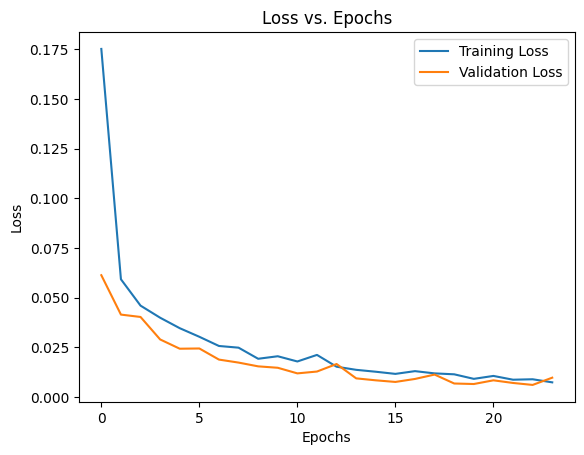

In [44]:
# Plotting the loss
history_df[['Training Loss','Validation Loss']].plot(title='Loss vs. Epochs',xlabel='Epochs',ylabel='Loss')
plt.show()

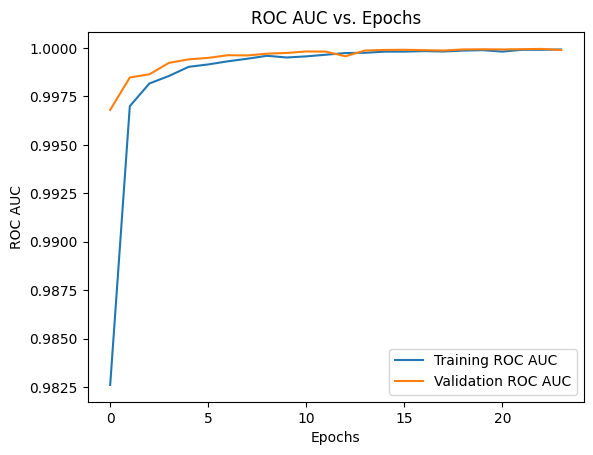

In [45]:
# Plotting the ROC AUC
history_df[['Training ROC AUC','Validation ROC AUC']].plot(title='ROC AUC vs. Epochs',xlabel='Epochs',ylabel='ROC AUC')
plt.show()

In [47]:
# Loading the best model
ann_clf = ANN(num_features,layers,include_dropout,dropout_rate)
ann_clf = torch.load('../../models/custom-features/ann.pt')

In [48]:
# Inference loop 
with torch.no_grad():
    model.eval()
    train_preds = None
    val_preds = None
    train_targets = None
    val_targets = None
    for X,y in training_loader:
        # Making predictions
        X = X.to(torch.float32)
        y = y.to(torch.float32)
        pred = model(X)
        if train_preds is None:
            train_preds = pred.detach().numpy()
        else:
            train_preds = np.append(train_preds,pred.detach().numpy(),axis=0)

        # Getting the targets
        if train_targets is None:
            train_targets = y.numpy()
        else:
            train_targets = np.append(train_targets,y.detach().numpy(),axis=0)
    for X,y in valid_loader:
        # Making predictions
        X = X.to(torch.float32)
        y = y.to(torch.float32)
        pred = model(X)
        if valid_preds is None:
            valid_preds = pred.detach().numpy()
        else:
            valid_preds = np.append(valid_preds,pred.detach().numpy(),axis=0)

        # Getting the targets
        if valid_targets is None:
            valid_targets = y.numpy()
        else:
            valid_targets = np.append(valid_targets,y.detach().numpy(),axis=0)

In [49]:
# Making predictions
print('Predictions for ANN')
train_score = roc_auc_score(train_targets,train_preds)
valid_score = roc_auc_score(valid_targets,valid_preds)
print(f'Training ROC AUC: {train_score}')
print(f'Validation ROC AUC: {valid_score}')

Predictions for ANN
Training ROC AUC: 0.999899626919739
Validation ROC AUC: 0.9998996269197389


In [50]:
# Adding the metrics
model = 'ANN'
performances['model'].append(model)
performances['Train ROC AUC'].append(train_score)
performances['Valid ROC AUC'].append(valid_score)

In [53]:
# Printing out the model performances in a dataframe and saving it
metrics_df = pd.DataFrame().from_dict(performances)
metrics_df

,model,Train ROC AUC,Valid ROC AUC
0,Logistic Regression,0.997460,0.931779
1,Decision Tree,1.000000,0.860053
2,Random Forest,1.000000,0.985907
3,Gradient Boosting,0.998616,0.978585
4,ANN,0.999900,0.999900


In [54]:
# Saving the performances
metrics_df.to_csv('../../models/custom-features/metrics.csv',index=False)